***

$$
\Large{\textbf{Conformal Prediction - UE TER 2023}}
$$

***

$$
\large{\text{Emilio PICARD - LPSM - Sorbonne University}}
$$

$$
    \text{By Claire Boyer}
$$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Introduction

**Goal of supervised learning** : Based on any models, with a dataset $(X_i,Y_i)_{i=1,...,n}$ and one data $X_{test}$, we can predict $Y$ wich belongs to $X_{test}$.

For $Y \in \mathbb{R}$, we will talk about prediction intervals with a threshold $1-\alpha$, where $\alpha$ is the expected error. On the following, it will be $\mathcal{\hat{C}}$.

For $Y \in \{1,...,C\}, \, \, C < \infty$, we will talk about prediction sets with a threshold $1-\alpha$, where $\alpha$ is also the expected error.

## Problem modelisation for $Y \in \mathbb{R}$

#### Assumptions

Suppose we have $(X_i,Y_i)_{i=1,...,n} \sim \mathcal{P}_{XY}, \, \, (X_i,Y_i) \, iid \, \, \, \forall i \in \{1,...,n\}$.
Our goal is to construct a prediction interval $\mathcal{\hat{C}}$ wich verify $\mathbb{P}(Y_{test} \in \mathcal{\hat{C}}(X_{test}) = 1-\alpha,$ for any distribution $\mathcal{P}_{XY}$, not necessarly known.

Definition of quantile function :
$$\text{Quantile}(1-\alpha,\mathbb{F})= \left\{ z:\mathbb{P}(Z\le z) \ge 1-\alpha \right\},$$
where $\mathbb{F}$ is the cumulative function of $Z \sim \mathcal{P}_{XY}$. 


On the following, we will see that $\mathbb{F}$ will be calculated empirically (wich makes sense because we haven't information about $\mathcal{P}_{XY}$, so it will be annotated as $\mathbb{F}_n$.

For a family $v_{1:n}=\{v_1,...,v_n\}$, let's define $$\text{Quantile}\left(1-\alpha;v_{1:n}\right) = \text{Quantile}\left(1-\alpha;\frac{1}{n}\sum_{i=1}^n\delta_{v_i}\right).$$

>**Proposition** : Si $V_1,...,V_n \,\,\, iid$, alors : $$\forall \,\, \alpha \in [0,1], \, \, \mathbb{P}\big(V_{n+1} \leq \text{Quantile}(1-\alpha;V_{1:n} \cup \{\infty\})\big) \ge 1-\alpha.$$
>>**Preuve.** notons $\beta = 1-\alpha$.
>>$$ \bigg\{V_{n+1} \leq \mathcal{Q}(\beta;V_{1:n} \cup \{\infty\})\bigg\} \Leftrightarrow \bigg\{ \frac{1}{n+1} \lvert j : V_j \leqslant V_{n+1} \rvert \leqslant \beta \bigg\}  \Leftrightarrow  \bigg\{\frac{\text{rank}(V_{n+1})-1}{n+1} \leq \beta \bigg\}  \Leftrightarrow  \bigg\{\text{rank}(V_{n+1}) \leq \beta(n+1) + 1 \bigg\} $$
>>Ainsi, $$\mathbb{P}\big(V_{n+1}\leq \text{Quantile}(\beta;V_{1:n}\cup\infty)\big) =\mathbb{P}\big(\text{rank}(V_{n+1})\leq 1+\beta(n+1)\big) = \frac{1+\beta(n+1)}{n+1}=\beta + \frac{1}{n+1} \ge \beta = 1-\alpha, $$ en utilisant le fait que $\text{rank}(V_{n+1})\sim \mathcal{U}\{1,...,n+1\}.
$
>>


Supposons maintenant que nous avons un dataset $\mathcal{Z}=(X_i,Y_i)_{i=1,...,n}$, et un point $(x,y)$ que nous allons tester. Il nous faut également une fonction Score, $\mathcal{S}((x,y),\mathcal{Z})$. Un score élevé nous indiquera que $(x,y)$ n'est pas conforme à notre modèle, tandis qu'un score petit indiquera que $(x,y)$ est conforme à $\mathcal{Z}$.

Dans le cadre de ce travail, nous utiliserons toujours la fonction score suivante :
$$
\mathcal{S}((x,y),\mathcal{Z}) = \lvert y - \hat{\mu}(x)\rvert,
$$

où $\hat{\mu}$ est une fonction de régression entraînée par un algorithme $\mathcal{A}$ sur $(x,y)$ et $\mathcal{Z}$. 
Pour un modèle de Régression linéaire, $\hat{\mu}$ sera l'estimateur des moindres carrés.

***

## **Différentes méthodes pour approcher $\hat{\mathcal{C}}$**

###  Full Conformal

###  Split Conformal

###  Jackknife +

###  Cross Validation +

**Remarque.** $\hat{\mathcal{C}}$ sera représenté graphiquement pour chacune des méthodes, et $\hat{\mu}$ sera calculé soit grâce aux k-plus proches voisins, soit par les moindres carrés.

In [4]:
np.random.seed(1)

Importation de SKLEARN pour implémenter le modèle

In [5]:
from sklearn.linear_model import LinearRegression
reg_OLS = LinearRegression()

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

k=9
reg_neigh = KNeighborsRegressor(n_neighbors = k)

***

# FULL CONFORMAL

#### Implémentation de l'algorithme.

Plutôt que de plot un intervalle de prédiction de niveau $\alpha$ fixé, nous allons plot des lignes de niveau $\alpha$.
Notre algorithme renverra donc un score $C\big(x_{test},y | \mathcal{Z})$.

Ce score est donc définit comme suit :
$$C\big(x_{test},y | \mathcal{Z}) = \dfrac{1}{n+1}\sum_i \mathbb{1}_{S_i \leq S^{(x_{test},y)}} = \mathbb{F}_n(S^{(x_{test},y)})$$
L'algorithme suivant renvoie donc $C\big(x_{test},y | \mathcal{Z})$.

In [293]:
def full_conformal(x,y,X_train,Y_train,reg):
    n = X_train.shape[0]
    reg.fit(np.append(X_train,x).reshape(n+1,1), np.append(Y_train,y).reshape(n+1,1)) #On fit sur toutes nos données
    
    V = np.zeros(n) #array qui contiendra tous les scores V_i
    for i in range(n):
        V[i] = np.abs(Y_train[i].reshape(1,1) - reg.predict(X_train[i].reshape(1,1))) #calcul des V_i
        
    V_ord = np.sort(V) #scores V triés dans l'ordre croissant
    return (1 + np.sum( V_ord<= np.abs(y - reg.predict(x.reshape(-1,1)))) ) / (n+1) #score C définit ci-dessus

## Affichage des résultats pour un modèle de régression linéaire

In [304]:
n, beta0 = 100, 7
x = np.random.rand(n,1)
y = beta0*x + 1/2*np.random.randn(n,1)
y = np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)
xlist = np.linspace(np.min(X_train), np.max(X_train), 30)
ylist = np.linspace(np.min(Y_train), np.max(Y_train), 20)

reg_OLS.fit(X_train,Y_train)

R = np.zeros((30, 20))
for i in range(30):
    for j in range(20):
        R[i,j] = full_conformal(xlist[i], ylist[j], X_train, Y_train, reg_OLS)

Le code suivant renvoie donc les intervalles de prédiction sous forme d'ensemble de niveaux de la fonction $C ( \cdot \, , \cdot | \mathcal{Z} )$.

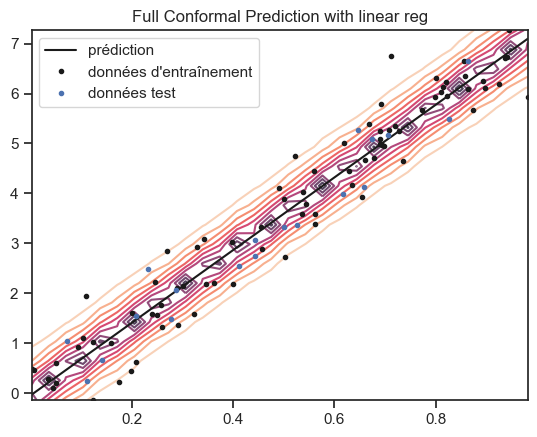

In [306]:
plt.contour(xlist.ravel(),ylist.ravel(), R.T, levels = np.linspace(0,1,11), alpha = .8)

plt.plot(xlist, reg_OLS.predict(xlist.reshape(-1,1)).ravel(), 'k-', label='prédiction')
plt.plot(X_train,Y_train, 'k.', label="données d'entraînement")
plt.axis([min(X_train),max(X_train),min(Y_train),max(Y_train)])
plt.plot(x_test,y_test,'b.', label='données test')
plt.legend()
plt.title("Full Conformal Prediction with linear reg")
plt.savefig("FCP intervals linReg")


plt.show()

## pour les $k$-plus proches voisins ( $k = 9$ )

In [307]:
n=120
x=4*np.random.rand(n,1) - 2
y = x**2 + 1/3*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.2)

xlist = np.linspace(np.min(X_train), np.max(X_train), 30)
ylist = np.linspace(np.min(Y_train), np.max(Y_train), 20)

k=9
reg_neigh = KNeighborsRegressor(n_neighbors = k)
reg_neigh.fit(X_train,Y_train)

R = np.zeros((30, 20))
for i in range(30):
    for j in range(20):
        R[i,j] = full_conformal(xlist[i], ylist[j], X_train, Y_train, reg_neigh)

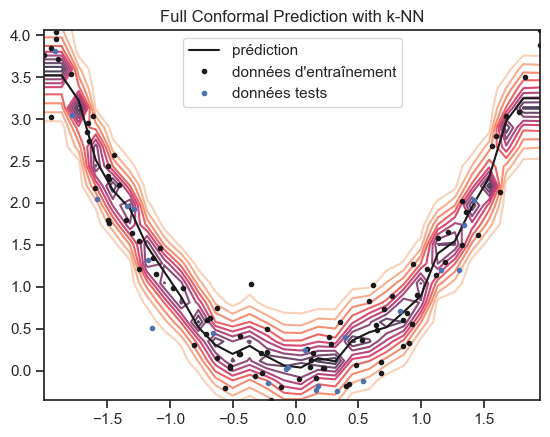

In [309]:
plt.contour(xlist.ravel(),ylist.ravel(), R.T, levels = np.linspace(0,1,11), alpha = .8)

plt.plot(xlist, reg_neigh.predict(xlist.reshape(-1,1)).ravel(), 'k-', label = 'prédiction')
plt.plot(X_train,Y_train, 'k.', label = "données d'entraînement")
plt.axis([min(X_train),max(X_train),min(Y_train),max(Y_train)])
plt.plot(x_test,y_test,'b.', label='données tests')
plt.legend()
plt.title("Full Conformal Prediction with k-NN")
plt.savefig("FCP intervals k-NN")

plt.show()

## **Remarques Full Conformal** :

Dans l'ensemble, marche bien mais couteux en calculs: Pour chaque nouveau candidat y, fit le modèle avec de nouvelles données, puis redécider si on accepte ou non le candidat dans $\hat{\mathcal{C}}$.

Une solution est d'utiliser la méthode suivante, le **Split Conformal**.

***

# SPLIT CONFORMAL

De manière survolée, consiste à calculer **une seule fois** $\hat{\mu}$ sur un set d'entraînement différent de l'ensemble des données que nous avons. Beaucoup moins coûteux que le Full Conformal.

**Problème** : on gaspille trop de données, car on utilise qu'une portion de celles-ci (les données non-utilisées servent tout de même à calibrer le résultat), donc $\hat{\mu}$ moins précis que dans le Full Conformal. 

>Construction :
>
>>1. Diviser notre jeux de données $(X_i,Y_i)_{i=1,...,n}$ en 2 : un jeux d'entraînement $(X_{train_i},Y_{train_i})_{i=1,...,n_{train}}$ et un de calibration $(X_{cal_i},Y_{cal_i})_{i=1,...,n_{cal}}$.
>>
>>2. Entraîner $\hat{\mu}$ sur $(X_{train_i},Y_{train_i})_{i=1,...,n_{train}}$
>>
>>3. Obtenir un set de $n_{cal} + 1$ scores :
>>$$
\mathcal{S} = \{S_i = \big|\hat{\mu}(X_i) - Y_i\big|, i \in \text{Calibration}\} \cup \{\infty \}
>>$$
>>
>>4. Calculer $\text{Quantile}\big(1-\alpha, \mathcal{S}\big)$ (noté $q_{1-\alpha}(\mathcal{S})$)
>>
>>5. Pour un nouveau point $X_{new}$, renvoyer
>>$$
\hat{\mathcal{C}}(X_{test}) = \Big[ \hat{\mu}(X_{test}) - q_{1-\alpha}(\mathcal{S}) ; \hat{\mu}(X_{test}) + q_{1-\alpha}(\mathcal{S})  \Big]$$

>**Théorème**:
>
>Le même résultat que précédemment s'applique au Split Conformal : 
>Sous les mêmes hypothèses que précédemment, avec l'intervalle de prédiction construit comme indiqué ci-dessus, on a, pour un seuil $\alpha \in [0,1]$,
>$$\mathbb{P}(y \in \hat{\mathcal{C}}(X_{test})) \ge 1-\alpha.$$

# SCP

In [4]:
def split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg, beta):
    
    '''
    x_cal, y_cal : données de calibrations, vecteurs
    X_train, Y_train : données  d'entraînement pour le modèle, vecteurs
    reg : algorithme qui va entraîner notre modèle et estimer 
    beta = 1 - alpha, niveau de confiance choisi

    '''
    n_cal=x_cal.shape[0]
    reg.fit(X_train, Y_train)
    
    V=np.zeros(n_cal)
    for i in range(n_cal):
        V[i] = np.abs(y_cal[i]-reg.predict(x_cal[i].reshape(-1,1))) #calcul des scores
    
    quantile = np.quantile(V,beta*(1+1/n_cal)) #quantile 1 - alpha de la fonction score empirique
    
    return quantile

# Jackknife+ prediction

In [102]:
def Jackknife_av_pred(x,X_train,Y_train,reg, alpha):

    '''
    x : donnée à tester, taille 1x1
    X_train, Y_train : Données que l'on va fit
    reg : modèle
    alpha : niveau de confiance

    '''
    n_train=X_train.shape[0]
    
    S_down, S_up = np.zeros(n_train), np.zeros(n_train) ### S_down et S_up sont l'ensemble des bornes de l'intervalle de prédiction
    
    for i in range(n_train):
        Reg=reg ##On stocke reg dans Reg pour ne pas modifier directement reg
        
        Reg.fit(np.delete(X_train,i).reshape(-1,1),np.delete(Y_train,i).reshape(-1,1)) ### à l'itération i, on entraîne nos données sans le couple (X_i,Y_i).
        V_loo = np.abs(Y_train[i] - Reg.predict(X_train[i].reshape(-1,1))) ### Scores LOO (Leave One Out) (car on enlève le couple (X_i,Y_i) à l'iter i)
        
        S_down[i] = Reg.predict(x.reshape(1,1)) - V_loo
        S_up[i] = Reg.predict(x.reshape(1,1)) + V_loo
    
    quantile_inf = np.quantile(S_down, alpha/2) ## quantile alpha/2 de S_down pour avoir notre borne inf
    quantile_sup = np.quantile(S_up, 1-alpha/2) ## quantile 1 - alpha/2 de S_up pour avoir notre borne sup
    
    return quantile_inf, quantile_sup ### returns :
                                            ## quantile_inf = borne inf pour le x_test
                                            ## quantile_sup = borne sup pour le x_test

# CV+ prediction

In [ ]:
def cross_val(x, X_train, Y_train, reg, k_fold, alpha):
    n_train = X_train.shape[0]
    kf = KFold(n_splits= k_fold)
    
    R_loo = np.zeros(n_train)
    S_down, S_up = np.zeros(n_train), np.zeros(n_train)
    
    for id_train, id_val in kf.split(X_train):
        
        Reg = reg
        Reg.fit(X_train[id_train], Y_train[id_train])
        R_loo[id_val]=np.abs(Y_train[id_val] - Reg.predict(X_train[id_val].reshape(-1,1)))
        
        S_down[id_val] = Reg.predict(x.reshape(1,1)) - R_loo[id_val]
        S_up[id_val] = Reg.predict(x.reshape(1,1)) + R_loo[id_val]
    
    quantile_inf = np.quantile(S_down, alpha/2)
    quantile_sup = np.quantile(S_up, 1-alpha/2)
    
    return quantile_inf, quantile_sup

## Pour la régression linéaire :

## DONNEES

In [117]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [105]:
n=300
x=np.random.rand(n,1)
y=beta0*x + 1/2*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.1)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

### Jackknife+:

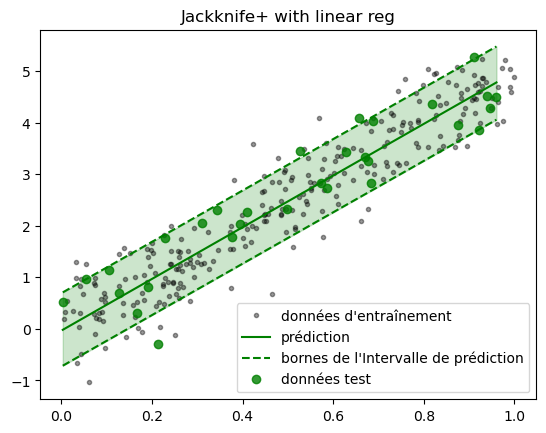

In [116]:
plt.plot(X_train, Y_train, 'k.', alpha=.4, label="données d'entraînement")
idx = np.argsort(np.ravel(x_test))
plt.plot(x_test[idx], reg_OLS.predict(x_test[idx]), 'g-', label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = Jackknife_av_pred(x_test[i],X_train,Y_train,reg_OLS, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'Intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color='green', alpha=.8, label='données test')
plt.legend()
plt.title("Jackknife+ with linear reg")
plt.savefig("Jackknife with linear reg")

plt.show()

### CV+

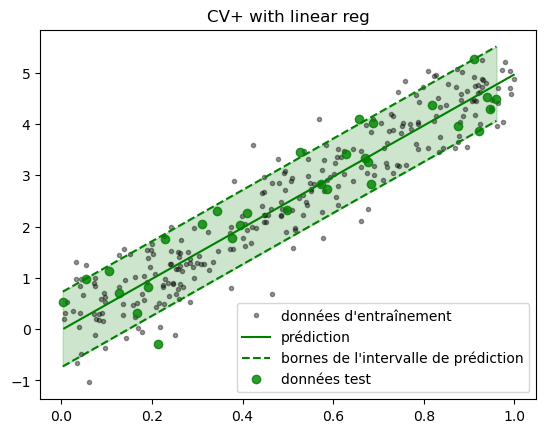

In [115]:
reg_OLS.fit(X_train,Y_train)

plt.plot(X_train, Y_train, 'k.',alpha=.4, label="données d'entraînement")
idx = np.argsort(np.ravel(X_train))
plt.plot(X_train[idx], reg_OLS.predict(X_train[idx]), 'g-',label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = cross_val(x_test[i],X_train,Y_train,reg_OLS, 9, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color='green', alpha=.8, label='données test')

plt.legend()

plt.title("CV+ with linear reg")
plt.savefig("CV+ with linear reg")

plt.show()

### SCP

In [96]:
X_train, x_cal, Y_train, y_cal = train_test_split(X_train, Y_train, test_size=0.2)

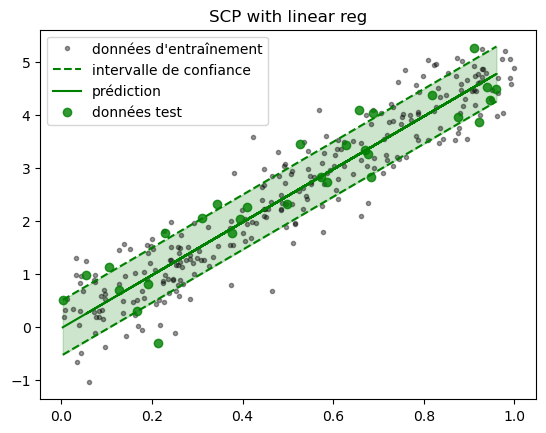

In [114]:
### Tracé de l'intervalle de prédiction à un niveau alpha donné, ici alpha = 0.1.
n_test=x_test.shape[0]
reg_OLS.fit(X_train,Y_train)

plt.plot(X_train,Y_train,'k.', alpha=.4, label="données d'entraînement")

SCP = split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg_OLS, 0.7)

idx = np.argsort(np.ravel(x_test))

low = reg_OLS.predict(x_test[idx]) - np.full(shape=(1,n_test), fill_value=SCP)
high = reg_OLS.predict(x_test[idx]) + np.full(shape=(1,n_test), fill_value=SCP)

plt.plot(x_test[idx],np.sort(low.ravel()),'g--',label='intervalle de confiance')
plt.plot(x_test[idx],np.sort(high.ravel()),'g--')
plt.plot(x_test, reg_OLS.predict(x_test), color='green',label='prédiction')

plt.fill_between(x_test[idx].reshape(-1,),np.sort(low[0,:]).reshape(-1,),np.sort(high[0,:]).reshape(-1,),color='green',alpha=.2)

plt.plot(x_test,y_test,'o', color='green',alpha=.8, label='données test')

plt.title("SCP with linear reg")
plt.legend()
plt.savefig("SCP intervals linear reg")


plt.show()

# Pour les k-NN

In [118]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# DONNEES

In [179]:
n=300
x=7*np.random.rand(n,1) + 1
y=3*np.cos(x)/x + 1/3*np.random.randn(n,1)
y=np.ravel(y)

X_train, x_test, Y_train, y_test = train_test_split(x,y,test_size=0.1)
n_train = X_train.shape[0]
n_test = x_test.shape[0]

### Jackknife+ k-NN

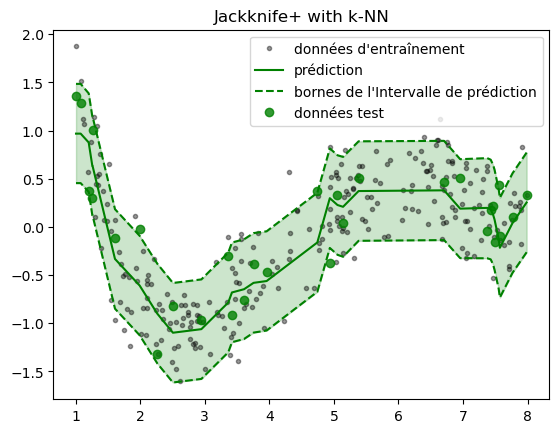

In [181]:
reg_neigh.fit(X_train,Y_train)
plt.plot(X_train, Y_train, 'k.', alpha=.4, label="données d'entraînement")
idx = np.argsort(np.ravel(x_test))
plt.plot(x_test[idx], reg_neigh.predict(x_test[idx]), 'g-',label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = Jackknife_av_pred(x_test[i],X_train,Y_train,reg_neigh, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'Intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color='g', alpha=.8, label='données test')

plt.legend()
plt.title("Jackknife+ with k-NN")
plt.savefig("Jackknife with k-NN")

plt.show()

### CV+ k-NN

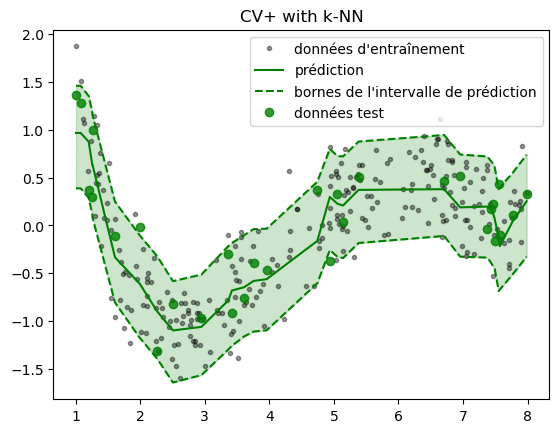

In [180]:
reg_neigh.fit(X_train,Y_train)

plt.plot(X_train, Y_train, 'k.', alpha=.4, label="données d'entraînement")
idx = np.argsort(np.ravel(x_test))
plt.plot(x_test[idx], reg_neigh.predict(x_test[idx]), 'g-',label='prédiction')

idx = np.argsort(np.ravel(x_test))

low = np.zeros(n_test)
high = np.zeros(n_test)

for i in range(n_test):
    low[i], high[i] = cross_val(x_test[i],X_train,Y_train,reg_neigh, 6, 0.3)

plt.plot(x_test[idx],low[idx], 'g--',label = "bornes de l'intervalle de prédiction")
plt.plot(x_test[idx],high[idx],'g--')    
    
plt.fill_between(x_test[idx].reshape(-1,),low[idx].reshape(-1,),high[idx].reshape(-1,),color='green',alpha=.2)
plt.plot(x_test,y_test,'o', color = 'g', alpha=.8, label='données test')

plt.legend()

plt.title("CV+ with k-NN")
plt.savefig("CV+ with k-NN")

plt.show()

### SCP k-NN

In [164]:
X_train, x_cal, Y_train, y_cal = train_test_split(X_train, Y_train, test_size=0.2)

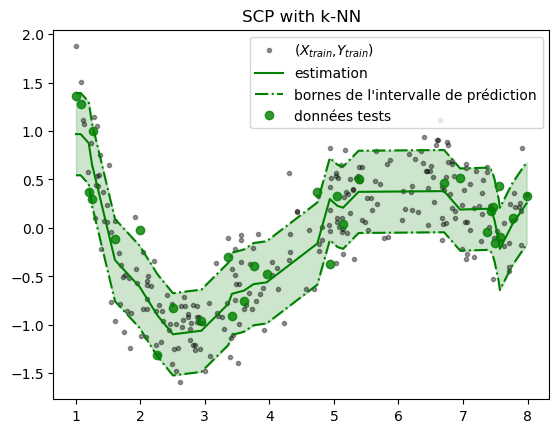

In [185]:
reg_neigh.fit(X_train, Y_train)
SCP = split_conformal_prediction(x_cal, y_cal, X_train, Y_train, reg_neigh, 0.7)

plt.plot(X_train.reshape(-1,),Y_train, 'k.', alpha=.4, label="($X_{train}$,$Y_{train}$)") 
plt.plot(np.sort(x_test[:,0]), reg_neigh.predict(np.sort(x_test[:,0]).reshape(-1,1)), color='green',label='estimation') # affichage de nos y estimés

idx = np.argsort(np.ravel(x_test))

low = reg_neigh.predict(x_test[idx]) - np.full(shape=(1,n_test), fill_value=SCP)
high = reg_neigh.predict(x_test[idx]) + np.full(shape=(1,n_test), fill_value=SCP)

plt.plot(x_test[idx], low.ravel() , 'g-.',label="bornes de l'intervalle de prédiction")
plt.plot(x_test[idx], high.ravel(), 'g-.')

plt.fill_between(x_test[idx].reshape(-1,), low.ravel(), high.ravel(),color='green',alpha=.2)

plt.plot(x_test,y_test,'o', color='g', alpha=.8, label='données tests')
plt.title("SCP with k-NN")
plt.legend()
plt.savefig("SCP intervals k-NN")

plt.show()

#### **Remarques :**

Bien que le Split Conformal soit moins coûteux en termes de calculs, le Full Conformal produit en général de meilleurs bornes de prédictions car l'algorithme utilise la totalité des données pour calculer $\hat{\mu}$.

Passons maintenant à la méthode Jackknife +, méthode plus optimale que le full conformal, moins que le split conformal, mais néanmoins plus précise.

***

# **CLASSIFICATION**

## Split conformal :

In [6]:
import sklearn
import pandas as pd
from sklearn.datasets import load_iris

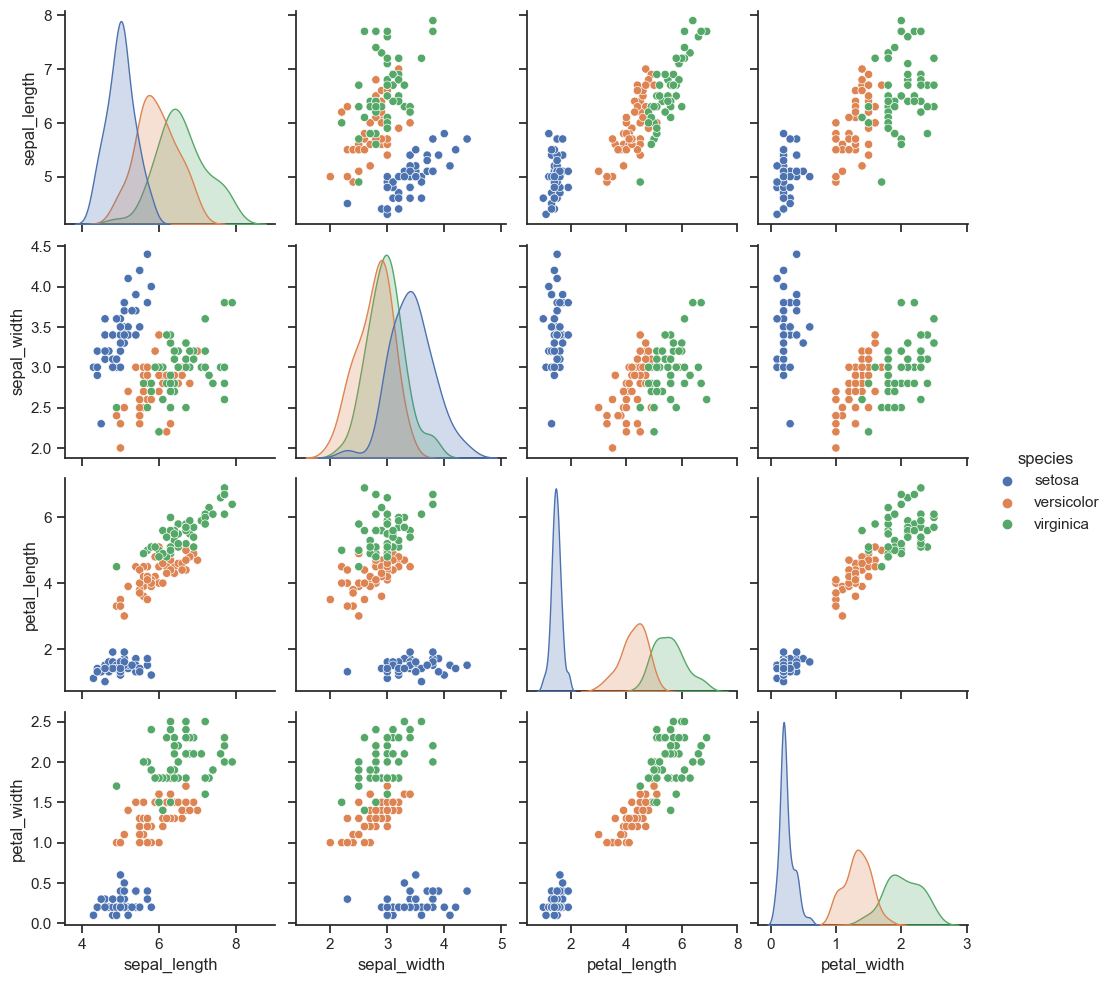

In [7]:
plantes_iris = load_iris()
df_plantes_iris = pd.DataFrame(plantes_iris.data, columns=plantes_iris.feature_names)

import seaborn as sns
sns.set(style="ticks", color_codes=True)
df_plantes_iris = sns.load_dataset("iris")
sns.pairplot(df_plantes_iris, hue="species")

labels = np.asarray(df_plantes_iris.species)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

df_selected1 = df_plantes_iris.drop(['sepal_length', 'sepal_width', "species"], axis=1)
df_features = df_selected1.to_dict(orient='records')
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()
features = vec.fit_transform(df_features).toarray()

In [8]:
X_train, x_cal, Y_train, y_cal = train_test_split(features, labels, test_size=0.20, random_state=0)

#### Création de l'algorithme de tri:

On se place dans le cas où $X \in \mathbb{R}^2$, $Y \in \{0, 1, 2\}$.

On peut rappeler qu'un classifieur est une fonction mesurable $h$ de $\mathcal{X}$ dans $\mathcal{Y}$. Ici, on aura $\mathcal{X}=\mathbb{R}^2$ et $\mathcal{Y}=\{0,1,2\}$.

Notre classifieur $h$ sera pour l'instant celui des plus proches voisins.
On a donc $h(X) \in \{0,1,2\}$. 

On peut récupérer les probabilités $\forall i \in \{1,...,n\}, \, \, \mathbb{P}(h(X_i) = k), \, \, k \in \{0,1,2\}$, que l'on notera $\hat{p}_k(X_i)$.

Voici l'algorithme à suivre:

1. Trier dans l'ordre décroissant les $\hat{p}_k(X_i)$: $\, \, \hat{p}_{\sigma_i(1)}(X_i) \geq \hat{p}_{\sigma_i(2)}(X_i) \geq \hat{p}_{\sigma_i(3)}(X_i)$.

2. Calculer tous les scores $S_i$ : $\, \, S_i = \sum_{k=1}^{\sigma_i^{-1}(Y_i)} \hat{p}_{\sigma_i(k)}(X_i)$

3. On renvoie à la fin les classes $\sigma_{new}(1), ..., \sigma_{new}(r^{\star})$, où
$$
r^{\star} = \text{argmax}_{1 \leq r \leq 3} \Bigg\{\sum_{k=1}^r\hat{p}_{\sigma_{new}(k)}(X_{new}) < q_{1-\alpha}(\mathcal{S})    \Bigg\} + 1
$$

In [9]:
from sklearn.neighbors import KNeighborsClassifier
reg_neigh = KNeighborsClassifier(n_neighbors = 9).fit(X_train, Y_train)

## Ensembles de prédiction naïfs

In [36]:
def SCP_classif_naif(X_train, Y_train, x_cal, y_cal, x, reg, alpha = 0.1):

    C = np.max(Y_train) + 1
    
    reg.fit(X_train, Y_train)
    
    prob_est = reg.predict_proba(x_cal)
    score = 1 - prob_est[np.arange(y_cal.size), y_cal]

    quantile = np.quantile(score,1-alpha)
    
    prob_x = reg.predict_proba(x.reshape(1,-1))
    score_x = 1 - prob_x
    
    pred = np.arange(C)[score_x.squeeze() <= quantile].squeeze()
    res = np.zeros(C, dtype=bool)
    res[pred] = True

    
    return res

### Interprétation graphique code précédent

In [37]:
data0 = np.linspace(2, 6, 40) 
data1 = np.linspace(0.4, 2.3,40) + 0.3*np.random.randn(40)

data =  np.column_stack((data0,data1))
preds = np.stack([SCP_classif_naif(X_train, Y_train, x_cal, y_cal, data[k], reg_neigh) for k in range(data.shape[0])])

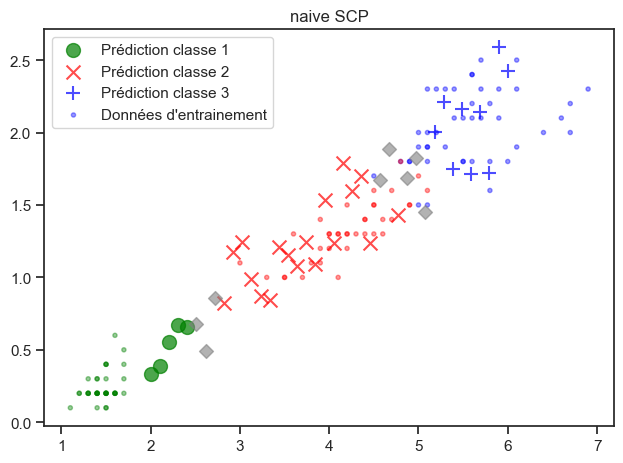

In [54]:
C = np.max(Y_train) + 1

fig, ax = plt.subplots(layout='tight')
markers = np.array(['o', 'x', '+'])
colors = np.array(['green', 'red', 'blue'])

for c in range(C):
    indices = preds[:,c] == True
    Xs = data[indices]
    ax.scatter(Xs[:,0], Xs[:,1], c=colors[c], marker=markers[c], s=100, alpha=.7, label=f"Prédiction classe {c + 1}")

ax.scatter(X_train[:,0], X_train[:,1], alpha=.4, marker='.', c=colors[Y_train], label="Données d'entrainement")

for i in range(len(preds)):
    if (preds[i,0], preds[i,1], preds[i,2]) == (False, False, False):
        ax.scatter(data[i,0], data[i,1], marker='D', s=50, color='gray',  alpha=.6)

ax.set_title("naive SCP")
ax.legend()

plt.savefig("SCP Naif 2")


plt.show()

## Adaptive prediction sets

In [55]:
def SCP_classif_aps(X_train, Y_train, x_cal, y_cal, x, reg, alpha = 0.1):
    reg.fit(X_train, Y_train)

    prob_est = reg.predict_proba(x_cal)
    cal_sorted_classes = np.fliplr(np.argsort(prob_est, axis=1))
    prob_est_sort = np.array([p[c] for (p, c) in zip(prob_est, cal_sorted_classes)])
    
    y_cal_sigma = cal_sorted_classes[np.arange(y_cal.size), y_cal]
    score = np.cumsum(prob_est_sort, axis = 1)[np.arange(y_cal.size), y_cal]

    quantile = np.quantile(score, 1-alpha)

    pred_x = reg.predict_proba(x.reshape(1,-1)).squeeze()
    sorted_classes = np.flip(np.argsort(pred_x))
    cumulative_preds = np.cumsum(pred_x[sorted_classes])
    r = 1 + (len(sorted_classes) - np.argmax(np.flip(cumulative_preds < quantile)) if (cumulative_preds < quantile).any() else 0)
    
    res = np.zeros(len(sorted_classes), dtype=bool)
    res[sorted_classes[:r]] = True
    return res

### Interprétation graphique du code ci-dessus :

In [56]:
print(SCP_classif_aps(X_train, Y_train, x_cal, y_cal, data[14], reg_neigh))

[False  True False]


In [57]:
preds = np.stack([SCP_classif_aps(X_train, Y_train, x_cal, y_cal, data[k], reg_neigh) for k in range(data.shape[0])])

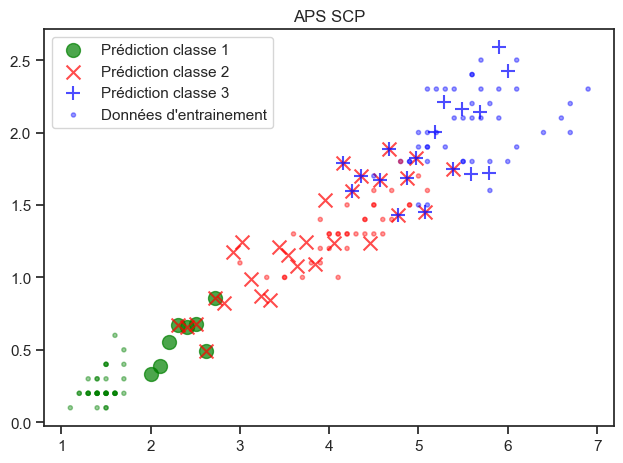

In [58]:
#plt.scatter(data0, data1, c = data_pred, marker='x', label='prédictions')
C = np.max(Y_train) + 1
fig, ax = plt.subplots(layout='tight')
markers = np.array(['o', 'x', '+'])
colors = np.array(['green', 'red', 'blue'])
for c in range(C):
    indices = preds[:,c] == True
    Xs = data[indices]
    ax.scatter(Xs[:,0], Xs[:,1], c=colors[c], marker=markers[c], s=100, alpha=.7, label=f"Prédiction classe {c+1}")
    
ax.scatter(X_train[:,0], X_train[:,1], alpha=.4, marker='.', c=colors[Y_train], label="Données d'entrainement")

ax.legend()
ax.set_title("APS SCP")
fig.savefig('scp aps example')
plt.show()

***

# **Sources**

- Gabriel Peyré - python OPTIMIZATION MACHINE LEARNING
- Anastasios N. Angelopoulos and Stephen Bates - A gentle introduction to Conformal Prediction and Distribution-free uncertainty Quantification
- Claire Boyer - Conformal Prediction